<a href="https://colab.research.google.com/github/venkat52/my_colab_notes/blob/main/Module1_Lab3_FMML20210326.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data augmentation

FMML Module 1, Lab 3<br>
 Module Coordinator: Thrupthi Ann John thrupthi.ann@research.iiit.ac.in <br>
 Release date: 18 October 2021 <br>

 In this lab, we will see how augmentation of data samples help in improving the machine learning performance

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
# set randomseed
rng = np.random.default_rng(seed=42)
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp
import math

Augmentation is useful when we have less training data available. Augmentation allows us to 'create' a larger dataset programatically. 

For this lab we will use a subset of MNIST that is very small, to better understand the effect of augmentation. 

In [129]:
#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X/255
test_X = test_X/255

train_X = train_X[::1200,:,:].copy() # subsample. Otherwise it will take too long!
train_y = train_y[::1200].copy() # do the same to the labels


Let us borrow a few functions from the previous labs:

In [130]:
def NN1(traindata, trainlabel, query):
  diff  = traindata - query  # find the difference between features. Numpy automatically takes care of the size here 
  sq = diff*diff # square the differences
  dist = sq.sum(1) # add up the squares
  label = trainlabel[np.argmin(dist)] # our predicted label is the label of the training data which has the least distance from the query
  return label

def NN(traindata, trainlabel, testdata):
  # we will run nearest neighbour for each sample in the test data 
  # and collect the predicted classes in an array using list comprehension
  traindata = traindata.reshape(-1, 28*28)
  testdata = testdata.reshape(-1,28*28)
  predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
  return predlabel

def Accuracy(gtlabel, predlabel):
  assert len(gtlabel)==len(predlabel), "Length of the groundtruth labels and predicted labels should be the same"
  correct = (gtlabel==predlabel).sum() # count the number of times the groundtruth label is equal to the predicted label.
  return correct/len(gtlabel)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time.<br>

Let us check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [131]:
testpred = NN(train_X, train_y, test_X)
print('Baseline accuracy without augmentation is ', Accuracy(test_y, testpred))

Baseline accuracy without augmentation is  0.6472


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits. 

### Augmentation 1: rotation

Let us try rotating the image a little. We will use skimage library for this. 

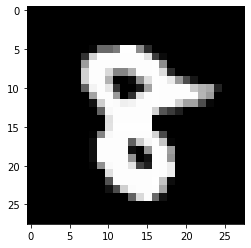

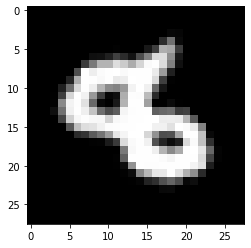

In [132]:
plt.imshow(train_X[2], cmap='gray')
plt.show()
plt.imshow(rotate(train_X[2],45), cmap='gray')

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [5]:
def augRotate(sample, angleconstraint):
  if angleconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(sample[ii], angle[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple. 

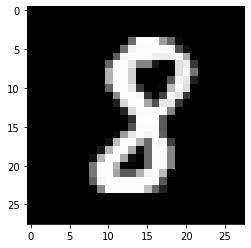

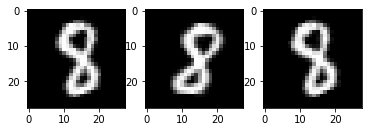

In [ ]:
sample = train_X[20]
angleconstraint = 70
# show the original image
plt.imshow(sample, cmap='gray')
plt.show()
plt.subplot(1,3,1)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show an augmented image
plt.subplot(1,3,2)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show another augmented image from the same sample
plt.subplot(1,3,3)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # one more image from the same sample

Let us augment the whole dataset and see if this improves the test accuracy

In [ ]:
# hyperparameters
angleconstraint = 60
naugmentations = 5

# augment
augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
  augdata = np.concatenate((augdata, augRotate(train_X, angleconstraint))) # concatenate the augmented data to the set
  auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print('Accuracy after rotation augmentation is ', Accuracy(test_y, testpred))

Accuracy after rotation augmentation is  0.6616


The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint.

In [ ]:
angleconstraints = [0,10,20,30,40,50,60,70,80,90] # the values we want to test
accuracies = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here

for ii in range(len(angleconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotate(train_X, angleconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after rotation augmentation constrained by ',angleconstraints[ii], ' is ', accuracies[ii], flush=True)

Accuracy after rotation augmentation constrained by  0  is  0.6472
Accuracy after rotation augmentation constrained by  10  is  0.6727
Accuracy after rotation augmentation constrained by  20  is  0.673
Accuracy after rotation augmentation constrained by  30  is  0.6737
Accuracy after rotation augmentation constrained by  40  is  0.6731
Accuracy after rotation augmentation constrained by  50  is  0.6701
Accuracy after rotation augmentation constrained by  60  is  0.6675
Accuracy after rotation augmentation constrained by  70  is  0.661
Accuracy after rotation augmentation constrained by  80  is  0.6462
Accuracy after rotation augmentation constrained by  90  is  0.6469


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

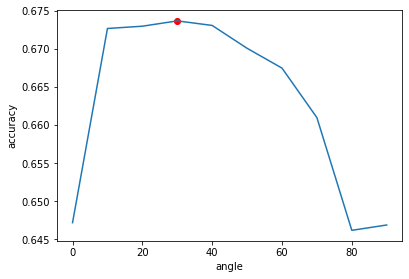

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c='red')

Let us try one more augmentation: shear. Here is what this looks like:

In [15]:
def shear(sample, amount):
  tform = AffineTransform(shear = amount) # create the shear transform
  img = warp(sample, tform) # apply the shear
  # this makes the digit off-center. Since all the images in the test set are centralized, we will do the same here
  col = img.sum(0).nonzero()[0]
  row = img.sum(1).nonzero()[0]
  if len(col)>0 and len(row)>0:
    xshift = int(sample.shape[0]/2 - (row[0]+row[-1])/2)
    yshift = int(sample.shape[1]/2 - (col[0]+col[-1])/2)
    img = np.roll(img, (xshift, yshift),(0,1))
  return img

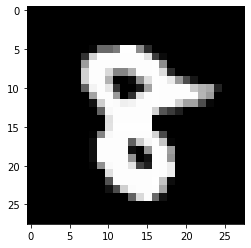

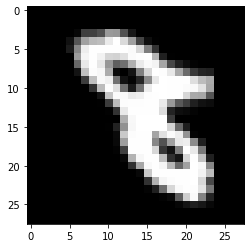

In [ ]:
sample = train_X[2]
plt.imshow(sample, cmap='gray')
plt.show()

# apply shear
plt.imshow(shear(sample, 0.4), cmap='gray')

Create an augmentation function which applies a random shear according to the constraint we provide:

In [6]:
def augShear(sample, shearconstraint):
  if shearconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = shear(sample[ii], amt[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

In [ ]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0] # the values we want to test
accuracies = np.zeros(len(shearconstraints), dtype=np.float) # we will save the values here

for ii in range(len(shearconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augShear(train_X, shearconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after shear augmentation constrained by ',shearconstraints[ii], ' is ', accuracies[ii], flush=True)

Accuracy after shear augmentation constrained by  0  is  0.6472
Accuracy after shear augmentation constrained by  0.2  is  0.6147
Accuracy after shear augmentation constrained by  0.4  is  0.632
Accuracy after shear augmentation constrained by  0.6  is  0.6351
Accuracy after shear augmentation constrained by  0.8  is  0.6636
Accuracy after shear augmentation constrained by  1.0  is  0.6652
Accuracy after shear augmentation constrained by  1.2  is  0.6495
Accuracy after shear augmentation constrained by  1.4  is  0.6181
Accuracy after shear augmentation constrained by  1.6  is  0.6323
Accuracy after shear augmentation constrained by  1.8  is  0.6432
Accuracy after shear augmentation constrained by  2.0  is  0.6277


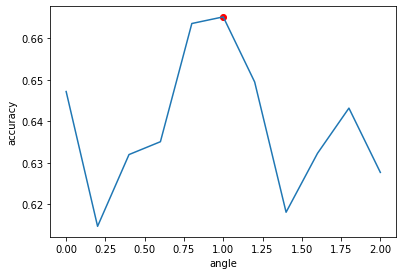

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c='red')

We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters. 

In [7]:
def augRotateShear(sample, angleconstraint, shearconstraint):
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(shear(sample[ii], amt[ii]), angle[ii]) # first apply shear, then rotate
  return np.squeeze(nsample) # take care if the input had only one sample.

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters. 

In [ ]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6] # the values we want to test
angleconstraints = [0,10,20,30,40,50,60] # the values we want to test
hyp = cartesian((shearconstraints, angleconstraints)) # cartesian product of both

accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here

for ii in range(len(hyp)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after augmentation shear:',hyp[ii][0], 'angle:',hyp[ii][1], ' is ', accuracies[ii], flush=True)

Accuracy after augmentation shear: 0.0 angle: 0.0  is  0.6332
Accuracy after augmentation shear: 0.0 angle: 10.0  is  0.6151
Accuracy after augmentation shear: 0.0 angle: 20.0  is  0.5997
Accuracy after augmentation shear: 0.0 angle: 30.0  is  0.5915
Accuracy after augmentation shear: 0.0 angle: 40.0  is  0.6198
Accuracy after augmentation shear: 0.0 angle: 50.0  is  0.6031
Accuracy after augmentation shear: 0.0 angle: 60.0  is  0.5916
Accuracy after augmentation shear: 0.2 angle: 0.0  is  0.634
Accuracy after augmentation shear: 0.2 angle: 10.0  is  0.5991
Accuracy after augmentation shear: 0.2 angle: 20.0  is  0.6044
Accuracy after augmentation shear: 0.2 angle: 30.0  is  0.6358
Accuracy after augmentation shear: 0.2 angle: 40.0  is  0.5827
Accuracy after augmentation shear: 0.2 angle: 50.0  is  0.579
Accuracy after augmentation shear: 0.2 angle: 60.0  is  0.5877
Accuracy after augmentation shear: 0.4 angle: 0.0  is  0.6344
Accuracy after augmentation shear: 0.4 angle: 10.0  is  0.61

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

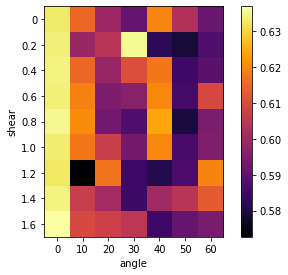

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
im = ax.imshow(accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap='inferno') 
ax.set_xlabel('angle')
ax.set_ylabel('shear')
ax.set_xticks(np.arange(len(angleconstraints)));
ax.set_xticklabels(angleconstraints);
ax.set_yticks(np.arange(len(shearconstraints)));
ax.set_yticklabels(shearconstraints);
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them. 
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
2. Can you increase the accuracy by increasing the number of augmentations from each sample?
3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch. 

**Answer to 1:** The Best Value of angle constraint is **0 degree** and the shear constraint is at **0.8,1.6**.If we see the accuracy by combining angle and shear is **lower** than without agumentation but if we consider individually like only by angle constraint the accuracys improves from **0.6472 to 0.6736** and by shear constraint accuracy improves by **0.6472 to 0.6652**

In [ ]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1] # the values we want to test
accuracies = np.zeros(len(shearconstraints), dtype=np.float) # we will save the values here
agumenation_list = [2,4,6,8,10,15]
for kk in agumenation_list:
  naugmentations = kk
  for ii in range(len(shearconstraints)):
    # create the augmented dataset
    augdata = train_X # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
      augdata = np.concatenate((augdata, augShear(train_X, shearconstraints[ii]))) # concatenate the augmented data to the set
      auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)


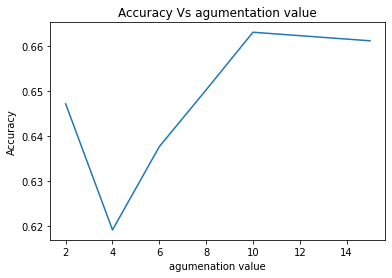

In [ ]:
plt.xlabel('agumenation value')
plt.ylabel('Accuracy')
plt.title('Accuracy Vs agumentation value')
plt.plot(agumenation_list,accuracies)

**ANswer to Q)2** From above graph we can see a trend of increase in accuracy as we increase the agumentation value

 My agumentations techinuqies are **Translation and Blurr** code of it shown below

In [43]:
def Translate(sample,x,y):
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)
  samp_data = sample.copy()
  # for i in range((samp_data.shape[0])):
  s=rng.random(len(samp_data))
  s=s-0.5
  for j in range(len(s)):
    trans = AffineTransform(translation=(s[j]*x,s[j]*y))
    samp_data[j] = warp(sample[j],trans,mode='wrap')
    # print(samp_data)
  return samp_data


In [ ]:
translation_list = [(0,0),(10,0),(0,10),(10,10),(20,0),(0,20),(20,20)]
auglabel = train_y
augdata = train_X
naugmentations=5
accur=[]
for p in range(len(translation_list)):
  x,y = translation_list[p]
  augdata = train_X.copy()
  auglabel = train_y.copy()
  for q in range(naugmentations):
    augdata = np.concatenate((augdata,Translate(train_X,x,y)))
    auglabel = np.concatenate((auglabel,train_y))
  pred = NN(augdata,auglabel,test_X)
  acc= Accuracy(test_y,pred)
  print("Accuracy for "+str(translation_list[p])+' translation: '+str(acc))
  accur.append(acc)

Accuracy for (0, 0) translation: 0.6472
Accuracy for (10, 0) translation: 0.6283
Accuracy for (0, 10) translation: 0.6282
Accuracy for (10, 10) translation: 0.6161
Accuracy for (20, 0) translation: 0.6151
Accuracy for (0, 20) translation: 0.6168
Accuracy for (20, 20) translation: 0.5712


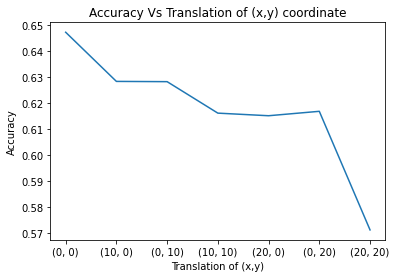

In [ ]:
for x in range(len(translation_list)):
  translation_list[x]=str(translation_list[x])
plt.xlabel('Translation of (x,y)')
plt.ylabel('Accuracy')
plt.title("Accuracy Vs Translation of (x,y) coordinate")
plt.plot(translation_list,accur)

In [9]:
from skimage.filters import gaussian

def blurr(data,x):
  samp_data = data.copy()
  s=rng.random(len(samp_data))
  s=s-0.5
  for j in range(len(s)):
    samp_data[j] = gaussian(data[j],sigma=x)
  return samp_data

In [ ]:
sigma = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
auglabel = train_y
augdata = train_X
naugmentations=5
accur=[]
for p in range(len(sigma)):
  augdata = train_X.copy()
  auglabel = train_y.copy()
  for q in range(naugmentations):
    augdata = np.concatenate((augdata,blurr(train_X,p)))
    auglabel = np.concatenate((auglabel,train_y))
  pred = NN(augdata,auglabel,test_X)
  acc= Accuracy(test_y,pred)
  print("Accuracy for sigma="+str(sigma[p])+' is : '+str(acc))
  accur.append(acc)

Accuracy for sigma=0 is : 0.6472
Accuracy for sigma=0.1 is : 0.6942
Accuracy for sigma=0.2 is : 0.7022
Accuracy for sigma=0.3 is : 0.6603
Accuracy for sigma=0.4 is : 0.6032
Accuracy for sigma=0.5 is : 0.5655
Accuracy for sigma=0.6 is : 0.5555
Accuracy for sigma=0.7 is : 0.558
Accuracy for sigma=0.8 is : 0.5651
Accuracy for sigma=0.9 is : 0.5759
Accuracy for sigma=1 is : 0.5872


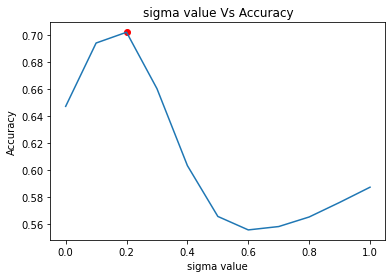

In [ ]:
plt.xlabel('sigma value')
plt.ylabel('Accuracy')
plt.title('sigma value Vs Accuracy')
plt.plot(sigma,accur)
s=np.argmax(accur)
plt.scatter(sigma[s],accur[s],color='red')

We can see that the the highest Accuracy value of Blurr agumenation is **70%** which is much better than all other agumentation which we look untill now as they highest accuracy is less than 70%

Below code is the Accuracy of test data set  with blurr and translation auguments

In [189]:
accur=[]
translation_list = [(0,0),(10,0),(0,10),(10,10),(20,0),(0,20),(20,20)]
sigma = [0.0,0.2,0.4,0.5,0.6,0.8,1]
naugmentations=5
for p in range(len(sigma)):
  augdata = train_X.copy()
  auglabel = train_y.copy()
  for r in range(nagumentations):
    augdata = np.concatenate((augdata,blurr(train_X,p)))
    auglabel = np.concatenate((auglabel,train_y))
  for q in range(len(translation_list)):
    x,y = translation_list[q]
    for r in range(naugmentations):
      augdata = np.concatenate((augdata,Translate(train_X,x,y)))
      auglabel = np.concatenate((auglabel,train_y))
    pred = NN(augdata,auglabel,test_X)
    acc= Accuracy(test_y,pred)
    print('Accuracy for sigma:'+str(sigma[p])+' and translation of (x,y) cordinates by '+str(translation_list[q])+': '+str(acc))
    accur.append(acc)

Accuracy for sigma:0.0 and translation of (x,y) cordinates by (0, 0): 0.6472
Accuracy for sigma:0.0 and translation of (x,y) cordinates by (10, 0): 0.6131
Accuracy for sigma:0.0 and translation of (x,y) cordinates by (0, 10): 0.6473
Accuracy for sigma:0.0 and translation of (x,y) cordinates by (10, 10): 0.6549
Accuracy for sigma:0.0 and translation of (x,y) cordinates by (20, 0): 0.6556
Accuracy for sigma:0.0 and translation of (x,y) cordinates by (0, 20): 0.66
Accuracy for sigma:0.0 and translation of (x,y) cordinates by (20, 20): 0.656
Accuracy for sigma:0.2 and translation of (x,y) cordinates by (0, 0): 0.6942
Accuracy for sigma:0.2 and translation of (x,y) cordinates by (10, 0): 0.6974
Accuracy for sigma:0.2 and translation of (x,y) cordinates by (0, 10): 0.6969
Accuracy for sigma:0.2 and translation of (x,y) cordinates by (10, 10): 0.6915
Accuracy for sigma:0.2 and translation of (x,y) cordinates by (20, 0): 0.6925
Accuracy for sigma:0.2 and translation of (x,y) cordinates by (0, 

Combining translation,shear and rotate






In [143]:
def augTranslateBlurrRotate(sample,a,b,c):
  # return sample
  x,y = a
  augdata = sample.copy()
  arr = rng.random(len(augdata))
  ang = (arr-0.5)*c
  for s in range(len(augdata)):
    augdata[s] = Translate(blurr(rotate(sample[s],ang[s]),b),x,y)
  return augdata
  # for p in range()
# augtranslateshearrotate(train_X,(0,0),0.5,60)
# augTranslateBlurrRotate(small_dataset,(0,0),sigma,45)

In [84]:
translation_list = [(0,0),(10,0),(10,10),(10,10)]
sigma_list = [0.0,0.4,0.6,0.8]
rotate_list =[0,30,60,90]
nagumentations=1
augdata = train_X.copy()
auglabel = train_y.copy()
for j in range(len(translation_list)):
  augdata = train_X.copy()
  auglabel = train_y.copy()
  for k in range(len(sigma_list)):
    for l in range(len(rotate_list)):
      for i in range((nagumentations)):

        augdata = np.concatenate((augdata,augTranslateBlurrRotate(train_X,translation_list[j],sigma_list[k],rotate_list[l])))
        auglabel = np.concatenate((auglabel,train_y))

        pred = NN(augdata,auglabel,test_X)
        acc= Accuracy(test_y,pred)
        print("accuracy for translate of "+str(translation_list[j])+' sigma constraint:'+str(sigma_list[k])+' rotatation :'+str(rotate_list[l])+' is :'+str(acc))
    

  

accuracy for translate of (0, 0) sigma constraint:0.0 rotatation :0 is :0.6472
accuracy for translate of (0, 0) sigma constraint:0.0 rotatation :30 is :0.6507
accuracy for translate of (0, 0) sigma constraint:0.0 rotatation :60 is :0.6548
accuracy for translate of (0, 0) sigma constraint:0.0 rotatation :90 is :0.654
accuracy for translate of (0, 0) sigma constraint:0.4 rotatation :0 is :0.6577
accuracy for translate of (0, 0) sigma constraint:0.4 rotatation :30 is :0.6637
accuracy for translate of (0, 0) sigma constraint:0.4 rotatation :60 is :0.6772
accuracy for translate of (0, 0) sigma constraint:0.4 rotatation :90 is :0.6769
accuracy for translate of (0, 0) sigma constraint:0.6 rotatation :0 is :0.6811
accuracy for translate of (0, 0) sigma constraint:0.6 rotatation :30 is :0.6817
accuracy for translate of (0, 0) sigma constraint:0.6 rotatation :60 is :0.6856
accuracy for translate of (0, 0) sigma constraint:0.6 rotatation :90 is :0.6883
accuracy for translate of (0, 0) sigma const

**Answer to Q)3** The Highest Accuracy fromthe mixed agumenation  was **70.37%** in combination of translation and blurr. where as the combination of translation,blurr and rotate give highest accuracy as **68.63%**

The smallest dataset is a set of each number only once let call it as small_datset
accuarcy  of small dataset without agumentation

In [156]:
small_dataset = None
(x,y),(p,q) = mnist.load_data()
for i in range(10):
  if small_dataset is None:
    small_dataset = x[y==i,:,:][0].reshape(1,28,28)
  else:
    small_dataset = np.concatenate((small_dataset,x[y==i,:,:][0].reshape(1,28,28)))
small_dataset = small_dataset/255
label = np.arange(10)

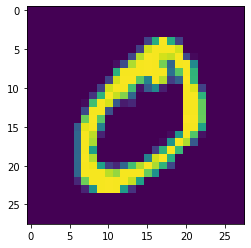

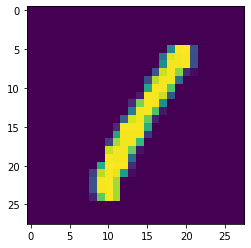

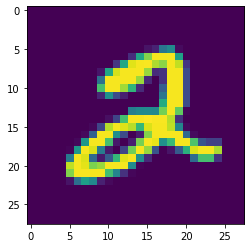

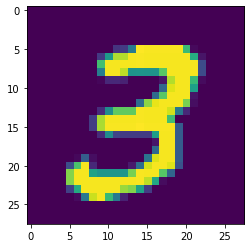

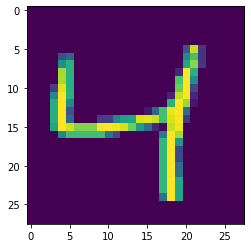

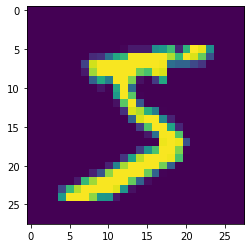

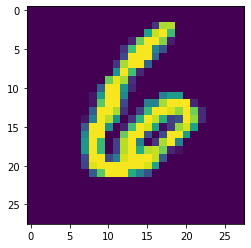

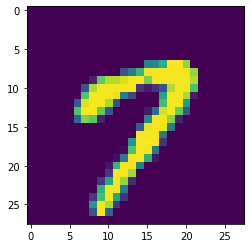

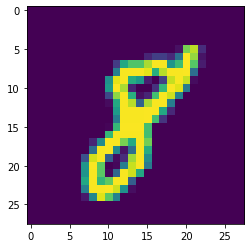

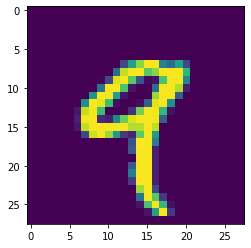

In [72]:
for x in small_dataset:
  plt.imshow(x)
  plt.show()


Without Agumentation

In [160]:
y=np.arange(10)
pred = NN(small_dataset,y,test_X)
Accuracy(test_y,pred)

0.5099

Here we use less number hyperparameters instead of running for long time

In [186]:
sigma=0.2
translation=np.array([0,0])
rotate_ang = 60
nagumentations=5
augdata = small_dataset
auglabel = label
for i in range(nagumentations):
  augdata = np.concatenate((augdata,(augTranslateBlurrRotate(small_dataset,i*translation,i*sigma,i*rotate_ang))))
  auglabel = np.concatenate((auglabel,label))
  pred = NN(augdata,auglabel,test_X)
  acc=Accuracy(test_y,pred)
  print('Accuracy with translation:'+str(translation*i)+'rotaion angle:'+str(rotate_ang*i)+'blurr with sigma:'+str(sigma*i)+' is :',acc) 

Accuracy with translation:[0 0]rotaion angle:0blurr with sigma:0.0 is : 0.5099
Accuracy with translation:[0 0]rotaion angle:60blurr with sigma:0.2 is : 0.5455
Accuracy with translation:[0 0]rotaion angle:120blurr with sigma:0.4 is : 0.5575
Accuracy with translation:[0 0]rotaion angle:180blurr with sigma:0.6000000000000001 is : 0.547
Accuracy with translation:[0 0]rotaion angle:240blurr with sigma:0.8 is : 0.5256


**Answer to Q)4** so the smallest data set that gives accuracy more than 50%  is 10 which contain each number only once.